In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms, rdmolops
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules
np.set_printoptions(precision=4)

In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [3]:
def featurize_mols(mol_files, max_n_atoms, n_bonds=5, get_angle=True):
    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 1 == 0:
            print(idx)
        try:
            if ".pdb" in mol_file:
                mol = Chem.MolFromPDBFile(mol_file)
            else:
                mol = Chem.MolFromMol2File(mol_file)
            if mol is None:
                features.append(None)
                continue
            
            mol_xyz = get_xyz_from_mol(mol)
            centroid = compute_centroid(mol_xyz)
            mol_xyz -= centroid
            temp = np.zeros((max_n_atoms, 3))
            try:
                temp[:mol_xyz.shape[0]] = mol_xyz
            except:
                features.append(None)
                continue
            mol_xyz = temp
            
            torsions = []
            torsion_tuples = []

            torsion_matrix = np.zeros((n_bonds,1))
            torsion_indices = np.zeros((n_bonds, max_n_atoms, 4)).astype(np.uint8)
            subgraphs = np.zeros((n_bonds, max_n_atoms, max_n_atoms)).astype(np.uint8)
            atom_index_of_bond = np.zeros((n_bonds, max_n_atoms)).astype(np.uint8)
            rot_vectors = np.zeros((n_bonds, 3))
            
            #mol_xyz = rotate_molecules([mol_xyz])[0]

            c = mol.GetConformer(0)
            idx = 0
            for bond in mol.GetBonds():
                if bond.IsInRing(): 
                    continue
                def calc_torsions(atom_i, atom_j, bond_idx):        
                    exist_dihed = False
                    for neighbor_j in atom_j.GetNeighbors():
                        if neighbor_j.GetIdx() == atom_i.GetIdx():
                            continue

                        dihed_idx = 0
                        for neighbor_i in atom_i.GetNeighbors():
                            if neighbor_i.GetIdx() == atom_j.GetIdx():
                                continue

                            exist_dihed=True
                            torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())

                            if get_angle:
                                torsion_matrix[bond_idx][dihed_idx] = rdMolTransforms.GetDihedralRad(c, *torsion_tuple)
                            torsion_indices[bond_idx][torsion_tuple[0]][dihed_idx*4] = 1
                            torsion_indices[bond_idx][torsion_tuple[1]][dihed_idx*4+1] = 1
                            torsion_indices[bond_idx][torsion_tuple[2]][dihed_idx*4+2] = 1
                            torsion_indices[bond_idx][torsion_tuple[3]][dihed_idx*4+3] = 1
                            
                            broken_mol = rdmolops.FragmentOnBonds(mol, [bond.GetIdx()], addDummies=False)
                            molfrags = rdmolops.GetMolFrags(broken_mol)
                            if bond.GetEndAtom().GetIdx() in molfrags[0]:
                                atoms_to_rotate = molfrags[0]
                            else:
                                atoms_to_rotate = molfrags[1]
                            print(mol.GetNumAtoms())
                            print(atoms_to_rotate)

                            subgraph = np.zeros((max_n_atoms, max_n_atoms)).astype(np.uint8)
                            for atom_idx in atoms_to_rotate:
                                subgraph[atom_idx,atom_idx] = 1
                            subgraphs[bond_idx, :, :] = subgraph
                            atom_index_of_bond[bond_idx, atom_j.GetIdx()] = 1
                            
                            pos_i = c.GetAtomPosition(atom_i.GetIdx())
                            pos_j = c.GetAtomPosition(atom_j.GetIdx())
                            pt_i = np.array([pos_i.x, pos_i.y, pos_i.z])
                            pt_j = np.array([pos_j.x, pos_j.y, pos_j.z])
                            vec = pt_j - pt_i
                            vec = vec / np.linalg.norm(vec)
                            rot_vectors[bond_idx] = vec
                
                            bond_idx += 1
                        break
                    return(bond_idx)
                
                if idx >= n_bonds: 
                    break
                idx = calc_torsions(bond.GetBeginAtom(), bond.GetEndAtom(), idx)
                
            graph_feat = featurizer.featurize([mol])[0]           
            features.append((mol_file, mol_xyz, torsion_indices, torsion_matrix, subgraphs, atom_index_of_bond, rot_vectors, graph_feat))
        except:
            features.append(None)
    return(features)

In [4]:
import pickle
max_n_atoms = 12
S = 64
feature_file = "./dihed_xyz_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[:96] + ["/home/evan/Documents/deep_docking/alanine_dipeptide.pdb"]*S  
    features = featurize_mols(ligand_files, max_n_atoms, n_bonds=1)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0
1
2
3
4
5
6
7
8
4
(2, 3)
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
12
(6, 7, 8)
30
31
32
33
34
35
36
9
(2, 3, 5, 6, 7)
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
12
(4, 5, 9, 10, 11)
53
12
(3, 4, 5, 6, 7, 8, 9, 10, 11)
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
10
(0, 1, 2)
97
10
(0, 1, 2)
98
10
(0, 1, 2)
99
10
(0, 1, 2)
100
10
(0, 1, 2)
101
10
(0, 1, 2)
102
10
(0, 1, 2)
103
10
(0, 1, 2)
104
10
(0, 1, 2)
105
10
(0, 1, 2)
106
10
(0, 1, 2)
107
10
(0, 1, 2)
108
10
(0, 1, 2)
109
10
(0, 1, 2)
110
10
(0, 1, 2)
111
10
(0, 1, 2)
112
10
(0, 1, 2)
113
10
(0, 1, 2)
114
10
(0, 1, 2)
115
10
(0, 1, 2)
116
10
(0, 1, 2)
117
10
(0, 1, 2)
118
10
(0, 1, 2)
119
10
(0, 1, 2)
120
10
(0, 1, 2)
121
10
(0, 1, 2)
122
10
(0, 1, 2)
123
10
(0, 1, 2)
124
10
(0, 1, 2)
125
10
(0, 1, 2)
126
10
(0, 1, 2)
127
10
(0, 1, 2)
128
10
(0, 1, 2)
129
10
(0, 1, 2)
130
10
(0, 1, 2)
131
10
(0, 1, 2)
132
10
(0, 1, 2)
133

In [5]:
features = [f for f in features if f is not None]
print(len(features))

68


In [22]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 1

S = 4

B = max_n_atoms
D = 1
p = 75

z_dim = 32

L_list = [p, 64, 64, 128, 256]

dihed_per_bond = 1
valence = 4



In [23]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    non_adj_matrix = tf.subtract(tf.ones_like(adj_matrix), adj_matrix)
    
    mol_xyz = tf.placeholder(tf.float32, shape=[S, B, 3], name="molxyz")
    
    z = tf.random_normal([S, D, z_dim], mean=0, stddev=1)
    
    mol_noise = tf.random_normal([S,D,1], mean=0,stddev=0.01)
    
    dihed_indices = tf.placeholder(tf.float32, shape=[S, D, B, 4])
    dihed_tensor = tf.placeholder(tf.float32, shape=[S, D, 1])
    rot_vectors = tf.placeholder(tf.float32, shape=[S, D, 3])
    atom_index_of_bond = tf.placeholder(tf.float32, shape=[S, D, B])
    subgraph = tf.placeholder(tf.float32, shape=[S, D, B, B])


In [24]:
#adapted from: http://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow
def compute_distance_matrix(A):
    r = tf.reduce_sum(A*A, 1) # turn r into column vector 
    r = tf.reshape(r, [-1, 1]) 
    D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
    return(D)

In [25]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x]
Dh_list = [x]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []
graph_stride = 1.
with tf.device('/gpu:0'):


    print("building clades and adj")
    for i in range(n_layers):
        print(i)
        B_list.append(int(np.ceil(B_list[i]/graph_stride)))
        print(B_list)
        clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],int(graph_stride)), depth=B_list[i])]*S, axis=0)) 


        adj_temp = tf.matmul(clades_list[i], adj_list[i])
        sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
        sub_adj = tf.minimum(sub_adj, 1.)
        adj_list.append(sub_adj)

    print("Building hidden layers")
    for layer_idx in range(n_layers):
        GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
        Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

        DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
        Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))

    f_w1 = tf.Variable(tf.truncated_normal([L_list[n_layers], L_list[n_layers]]))
    f_b1 = tf.Variable(tf.ones([L_list[n_layers]]))

    g_w1_ini = tf.Variable(tf.truncated_normal([1, L_list[n_layers]*5+z_dim, 64]))
    g_w1 = tf.tile(g_w1_ini, [S, 1, 1])

    g_b1 = tf.Variable(tf.ones([1, 1, 64]))

    g_w2_ini = tf.Variable(tf.truncated_normal([1, 64, 64]))
    g_w2 = tf.tile(g_w2_ini, [S, 1, 1])

    g_b2 = tf.Variable(tf.ones([1, 1, 64]))

    g_w3_ini = tf.Variable(tf.truncated_normal([1, 64, 1]))
    g_w3 = tf.tile(g_w3_ini, [S, 1, 1])
    g_b3 = tf.Variable(tf.ones([1, 1, 1]))

    dd_w1 = tf.Variable(tf.truncated_normal([L_list[n_layers]*5+1, 32]))
    dd_b1 = tf.Variable(tf.truncated_normal([1, 32]))

    dd_w2 = tf.Variable(tf.truncated_normal([32, 1]))
    dd_b2 = tf.Variable(tf.truncated_normal([1,1]))

    d_w1_ini = tf.Variable(tf.truncated_normal([1, B*(L_list[n_layers]*2+1), 32]))
    d_w1 = tf.tile(d_w1_ini, [S, 1, 1])
    d_b1 = tf.Variable(tf.ones([1, 1, 32]))

    d_w2_ini = tf.Variable(tf.truncated_normal([1, 32, 1]))
    d_w2 = tf.tile(d_w2_ini, [S, 1, 1])
    d_b2 = tf.Variable(tf.ones([1, 1, 1]))

    lam1 = tf.Variable(tf.constant(0.01))
    lam2 = tf.Variable(tf.constant(0.01))
    lam3 = tf.Variable(tf.constant(0.01))

building clades and adj
0
[12, 12]
Building hidden layers


In [26]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [27]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [28]:
def compute_angle_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)

def compute_dist_tensor(mols_batch):
    dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols_batch, S, axis=0)], axis=0)
    #dist_matrix = tf.where(tf.is_nan(dist_matrix), tf.ones_like(dist_matrix) * 0., dist_matrix)
    print("dist_matrix")
    print(dist_matrix)
    #dist_matrix = compute_distance_matrix(mol)
    return(dist_matrix)

def compute_rot_matrix(t, vec):
    x, y, z = vec[0], vec[1], vec[2]
    rot_matrix = tf.reshape(tf.stack([tf.cos(t) + tf.square(x) * (1 - tf.cos(t)), 
                               x*y*(1-tf.cos(t)) - z*tf.sin(t),
                               x*z*(1-tf.cos(t)) + y*tf.sin(t),
                              y*x*(1-tf.cos(t)) + z*tf.sin(t),
                               tf.cos(t) + y*y*(1-tf.cos(t)),
                               y*z*(1-tf.cos(t)) - x*tf.sin(t),
                              z*x*(1-tf.cos(t)) - y*tf.sin(t),
                               z*y*(1-tf.cos(t)) + x*tf.sin(t),
                               tf.cos(t)+ z*z*(1-tf.cos(t))]), (3,3))
    return(rot_matrix)

"""
def compute_dihedral_tensor(mols_batch, angle_tuples_batch):
    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])
    i_vec = tf.tile(i_vec, [1, 1, B, 1])

    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])
    j_vec = tf.tile(j_vec, [1, B, 1, 1])

    diff = tf.subtract(i_vec, j_vec)
    temp = tf.eye(B, batch_shape=[S])
    temp = tf.reshape(temp, [S, B, B, 1])
    temp = tf.tile(temp, [1, 1, 1, 3])
    diff = diff + temp
    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))
    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))
    diff = tf.subtract(diff, temp)

    print("diff should be [S, B, B, 3]")
    print(diff)

    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])
    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])
    cross = tf.cross(ij, ik)
    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))
    
    ijk = tf.tile(tf.reshape(cross, [S, B, B, 1, B, 3]), [1m 1])
    
    dps = tf.reduce_sum(tf.multiply(ij ,ik), axis=4)
    #dps = tf.where(tf.is_nan(dps), tf.ones_like(dps) * 0., dps)
    print("dps should be [S, B, B, B]")
    print(dps)

    #angles_gen = tf.acos(tf.clip_by_value(dps, -1.0, 1.0))
    angles_computed = tf.where(tf.is_nan(dps), tf.zeros_like(dps), dps)
    angles_computed = tf.multiply(angles_computed, angle_tuples_batch)
    return(angles_computed)
"""

'\ndef compute_dihedral_tensor(mols_batch, angle_tuples_batch):\n    i_vec = tf.reshape(mols_batch, [S, B, 1, 3])\n    i_vec = tf.tile(i_vec, [1, 1, B, 1])\n\n    j_vec = tf.reshape(mols_batch, [S, 1, B, 3])\n    j_vec = tf.tile(j_vec, [1, B, 1, 1])\n\n    diff = tf.subtract(i_vec, j_vec)\n    temp = tf.eye(B, batch_shape=[S])\n    temp = tf.reshape(temp, [S, B, B, 1])\n    temp = tf.tile(temp, [1, 1, 1, 3])\n    diff = diff + temp\n    diff = diff / tf.sqrt(tf.reduce_sum(tf.square(diff), axis=3, keep_dims=True))\n    temp = tf.sqrt(tf.reduce_sum(tf.square(temp), axis=3, keep_dims=True))\n    diff = tf.subtract(diff, temp)\n\n    print("diff should be [S, B, B, 3]")\n    print(diff)\n\n    ij = tf.tile(tf.reshape(diff, [S, B, 1, B, 3]), [1, 1, B, 1, 1])\n    ik = tf.tile(tf.reshape(diff, [S, B, B, 1, 3]), [1, 1, 1, B, 1])\n    cross = tf.cross(ij, ik)\n    cross = cross / tf.sqrt(tf.reduce_sum(tf.square(cross), axis=4, keep_dims=True))\n    \n    ijk = tf.tile(tf.reshape(cross, [S, B, 

In [29]:
def generator(W_list, b_list, h_list, L_list, n_layers, mols):
    for layer_idx in range(n_layers):
        h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                     b_list[layer_idx], adj_list[layer_idx], 
                                                     clades_list[layer_idx],
                                                     L_list[layer_idx], L_list[layer_idx+1],
                                                     layer_idx, S, B_list[layer_idx]), keep_prob))
    L_final = L_list[n_layers]  
    
    print("h_list[-1]")
    print(h_list[-1])
    
    print("B_list")
    print(B_list)
    
    fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_w1) + f_b1), [S, 1, L_final]), [1, D, 1])
    h_final = h_list[-1]
    
    d0 = []
    for l in range(0, valence*dihed_per_bond):
        d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))
    
    d0 = tf.concat(d0, axis=2)
    print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4))))
    d0 = tf.concat([d0, fingerprints, z], axis=2)
    
    #PREDICT ANGLES:
    g_h1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d0, g_w1) + g_b1), keep_prob)
    #g_h1 = tf.reshape(g_h1, [S, 5, 16])
    print("g_h1")
    print(g_h1)
    g_h2 = tf.nn.tanh(tf.matmul(g_h1, g_w2) + g_b2)

    g_h3 = tf.reshape(tf.matmul(g_h2, g_w3) + g_b3, [S, D, 1])
    g_h3 = tf.atan2(tf.sin(g_h3), tf.cos(g_h3))
    
    
    #ROTATE MOLECULE: 
    #for i in range(n_bonds):
        #rotation point: atom_index_of_bond * mol_xyz
        #
        #rot_mat = compute_rotation_matrix(old_angle - g_h2, axis)
        #new_xyz = rot_mat*subgraph*xyz + (1-subgraph)*xyz
    
    new_mols = []
    for i in range(0,S):
        mol = mol_xyz[i]
        for j in range(0,D):
            rot_point = tf.matmul(tf.reshape(atom_index_of_bond[i,j,:], (1, B)), mol)
            mol = tf.subtract(mol, rot_point)
            rot_mat = compute_rot_matrix(tf.subtract(g_h3[i, j], dihed_tensor[i, j]), rot_vectors[i, j])
            if i ==0 and j ==0:
                rot_mat_i = rot_mat
            
            frag_i = tf.transpose(tf.matmul(subgraph[i, j, :, :], mol), perm=[1,0])
            new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[1,0])
            
            other_subgraph = tf.subtract(tf.eye(B), subgraph[i, j, :, :])
            mol = tf.add(new_xyz, tf.matmul(other_subgraph, mol))
        new_mols.append(mol)
    new_mol = tf.stack(new_mols, axis=0)
            
    """
    for i in range(D):
        rot_point = tf.matmul(tf.reshape(atom_index_of_bond[:,i,:], (S, 1, B)), mol_xyz)
        tf.subtract(mol_xyz, rot_point)
        rot_mat = []
        for j in range(0,S):
            rot_mat.append(tf.reshape(compute_rot_matrix(tf.subtract(g_h3[j, i], dihed_tensor[j, i]), rot_vectors[j, i]), [1, 3, 3]))
        rot_mat = tf.concat(rot_mat, axis=0)
        if i == 0:
            rot_mat_i = rot_mat
            
        frag_i = tf.transpose(tf.matmul(subgraph[:, i, :, :], mol_xyz), perm=[0,2,1])
        new_xyz = tf.transpose(tf.matmul(rot_mat, frag_i), perm=[0,2,1])
        
        other_subgraph = tf.subtract(tf.tile(tf.reshape(tf.eye(B), [1, B, B]), [S, 1, 1]), subgraph[:, i, :, :])
        new_xyz = tf.add(new_xyz, tf.matmul(other_subgraph, mol_xyz))
    """
    return(new_mol, g_h3, rot_mat_i)



In [30]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mol_real, mol_gen, dihed):
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))        
        #DIHEDRAL LOSS:
        fingerprints = tf.tile(tf.reshape(tf.nn.tanh(tf.matmul(tf.reduce_sum(h_list[-1], axis=1), f_w1) + f_b1), [S, 1, L_list[n_layers]]), [1, D, 1])
        h_final = h_list[-1]

        d0 = []
        for l in range(0, valence*dihed_per_bond):
            d0.append(tf.matmul(dihed_indices[:,:,:,l], h_final, name="dihed_mult"))

        d0 = tf.concat(d0, axis=2)
        print("d0 should be shape %s" %(str((S, D, L_list[n_layers]*4))))
        print(d0)
        d0 = tf.concat([d0, fingerprints, dihed], axis=2)
        d0 = tf.reshape(d0, [S*D, L_list[n_layers]*4 + L_list[n_layers]+1])
        
        d1 = tf.nn.tanh(tf.matmul(d0, dd_w1) + dd_b1)
        d2 = tf.nn.tanh(tf.matmul(d1, dd_w2) + dd_b2)
        d2 = tf.reshape(d2, [S, D])
        d2 = tf.reduce_mean(d2, axis=1, keep_dims=True)
        
        
        #COMPUTE CONTACT LOSS:
        
        dist_real = compute_dist_tensor(mol_real)
        dist_fake = compute_dist_tensor(mol_gen)
        
        dist_loss = tf.multiply(tf.reduce_sum(tf.squared_difference(dist_fake, dist_real), axis=[1,2]), lam1)
        
        """
        contact_dist = tf.multiply(dist_matrix_gen, non_adj_matrix)
        contact_loss = tf.multiply(tf.reshape(tf.reduce_mean(tf.exp(tf.multiply(tf.multiply(tf.subtract(contact_dist, 2.), -1.), 3.)), axis=[1,2]), (S,1)), lam3)        
        
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix_gen, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = tf.nn.dropout(tf.nn.tanh(tf.matmul(d_h1, d_w1) + d_b1), keep_prob)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        """
    
    return(tf.add(0., dist_loss))

In [31]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d_w1_ini, d_b1, d_w2_ini, d_b2, dd_w1, dd_b1, dd_w2, dd_b2, lam1]

theta_G =  GW_list[:n_layers] + Gb_list[:n_layers] + [g_w1_ini, g_b1, g_w2_ini, g_b2, g_w3_ini, g_b3, f_w1, f_b1]

In [32]:
import time 

#with tf.device('/gpu:0'):
if 1==1:

    G_sample, dihed, rot_mat_i = generator(GW_list, Gb_list, Gh_list, L_list, n_layers, mol_xyz)

    D_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, mol_xyz, dihed_tensor + mol_noise)
    D_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, G_sample, dihed)


    # WGAN lipschitz-penalty
    alpha = tf.random_uniform(
        shape=[S,1,1], 
        minval=0.,
        maxval=1.
    )
    differences = dihed_tensor - dihed
    interpolates = dihed_tensor + (alpha*differences)
    gradients = tf.gradients(discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_xyz, mol_xyz, interpolates), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    LAMBDA = 10
    disc_cost += LAMBDA*gradient_penalty

    gen_params = theta_G
    disc_params = theta_D

    gen_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(gen_cost, var_list=gen_params)
    disc_train_op = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(disc_cost, var_list=disc_params)


    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = []
    for p in theta_D[:-1]:
        #print(p)
        clip_D.append(p.assign(tf.clip_by_value(p, -0.01, 0.01)))
    clip_D.append(lam1.assign(tf.clip_by_value(lam1, 0.001, 0.01)))

    
    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-4)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))


    

layer_idx: 0
within func h:
Tensor("MatMul_2:0", shape=(4, 12, 64), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("dropout/mul:0", shape=(4, 12, 64), dtype=float32)
B_list
[12, 12]
d0 should be shape (4, 1, 256)
g_h1
Tensor("dropout_1/mul:0", shape=(4, 1, 64), dtype=float32)
layer_idx: 0
within func h:
Tensor("MatMul_23:0", shape=(4, 12, 64), dtype=float32, device=/device:GPU:0)
d0 should be shape (4, 1, 256)
Tensor("concat_2:0", shape=(4, 1, 256), dtype=float32, device=/device:GPU:0)
dist_matrix
Tensor("concat_4:0", shape=(4, 12, 12), dtype=float32, device=/device:GPU:0)
dist_matrix
Tensor("concat_5:0", shape=(4, 12, 12), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_35:0", shape=(4, 12, 64), dtype=float32, device=/device:GPU:0)
d0 should be shape (4, 1, 256)
Tensor("concat_6:0", shape=(4, 1, 256), dtype=float32, device=/device:GPU:0)
dist_matrix
Tensor("concat_8:0", shape=(4, 12, 12), dtype=float32, device=/device:GPU:0)
dist_matrix
Tensor("

In [33]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob_val=1.0, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][7][0] for idx in inds]
    
    A_batch = np.array([X[idx][7][1] for idx in inds])
    mol_xyz_batch = [X[idx][1] for idx in inds]
    dihed_tuples_batch = [X[idx][2] for idx in inds]
    dihed_tensor_batch = [X[idx][3] for idx in inds]
    subgraph_batch = [X[idx][4] for idx in inds]
    atom_index_of_bond_batch = [X[idx][5] for idx in inds]
    rot_vectors_batch = [X[idx][6] for idx in inds]
    

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_xyz: mol_xyz_batch,
                 dihed_indices: dihed_tuples_batch,
                 dihed_tensor: dihed_tensor_batch,
                 subgraph: subgraph_batch,
                 atom_index_of_bond: atom_index_of_bond_batch,
                 rot_vectors: rot_vectors_batch,
                 keep_prob: keep_prob_val
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [34]:
features[0][4]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [35]:
def generate_molecule(mol_file, new_coords, new_file):
    print(mol_file)
    print(new_coords[:4])
    if ".pdb" in mol_file:
        mol = Chem.MolFromPDBFile(mol_file)
    else:
        mol = Chem.MolFromMol2File(mol_file)
    c = mol.GetConformer(0)
    for i in range(mol.GetNumAtoms()):
        c.SetAtomPosition(i, new_coords[i].tolist())
    Chem.MolToMolFile(mol, new_file)

In [36]:
features[1][0]

'/home/evan/Documents/deep_docking/datasets/v2015/2ohk/2ohk_ligand.mol2'

0.281429052353
Training epoch 0
Iter: 0
D loss: -0.6165
G_loss: -0.3613
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [ 0.4745  0.9955  0.9053]]
fake:
[[ 0.2913  0.7867  0.5443]
 [-0.9553  0.2093  0.2087]
 [ 0.0503 -0.5807  0.8125]]
0.18187


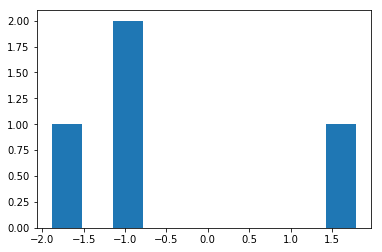

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.553  -1.0512  0.7905]]
0.0363399982452
Training epoch 100
Iter: 100
D loss: -0.0558
G_loss: -0.04459
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [ 0.9312  0.8569  0.659 ]]
fake:
[[-0.4282  0.4602  0.7777]
 [-0.7999 -0.5934 -0.0893]
 [ 0.4204 -0.6604  0.6222]]
-2.01651


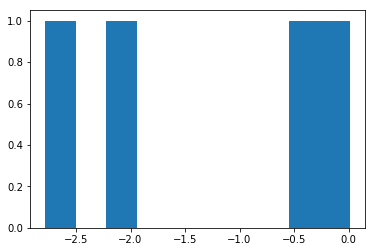

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7746  0.0307  1.1978]]
0.0211710929871
Training epoch 200
Iter: 200
D loss: -0.155
G_loss: -0.01746
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [ 1.2114 -0.7499  0.0764]]
fake:
[[-0.3381 -0.8696  0.3598]
 [ 0.5513 -0.4929 -0.6732]
 [ 0.7627 -0.0293  0.646 ]]
-2.02252


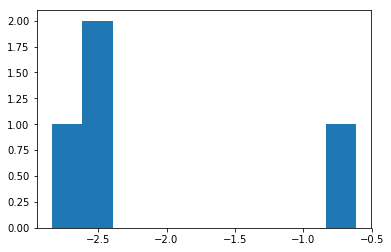

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.4339  0.6188  1.2101]]
0.0233099460602
Training epoch 300
Iter: 300
D loss: -0.1186
G_loss: -0.109
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.2856 -1.2573  0.6109]]
fake:
[[ 0.9648  0.2485  0.0864]
 [-0.2569  0.9607  0.1053]
 [-0.0569 -0.1238  0.9907]]
-0.554059


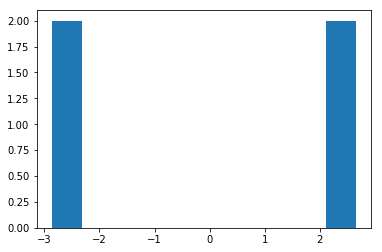

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.8165 -0.4468  1.0813]]
0.0214440822601
Training epoch 400
Iter: 400
D loss: -0.1563
G_loss: -0.1247
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7837 -0.0032  1.1923]]
fake:
[[ 0.0552 -0.9874  0.1482]
 [ 0.7626 -0.0541 -0.6446]
 [ 0.6445  0.1486  0.7501]]
-1.81731


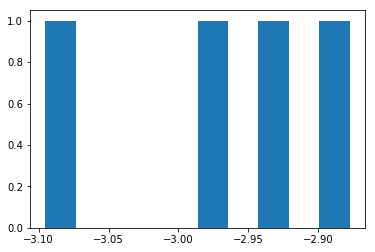

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7373  0.144   1.213 ]]
0.0211079120636
Training epoch 500
Iter: 500
D loss: -0.2197
G_loss: -0.1037
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.4653  0.5856  1.215 ]]
fake:
[[-0.0461 -0.9795  0.1963]
 [ 0.7306 -0.1671 -0.6621]
 [ 0.6813  0.1129  0.7233]]
-2.87738


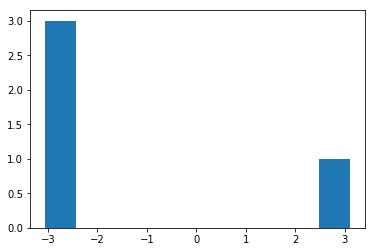

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.6784  0.2774  1.2241]]
0.0212209224701
Training epoch 600
Iter: 600
D loss: -0.2182
G_loss: -0.1091
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7368  0.1452  1.2131]]
fake:
[[-0.6328 -0.4874  0.6017]
 [ 0.0989 -0.8216 -0.5614]
 [ 0.768  -0.2957  0.5681]]
-1.46375


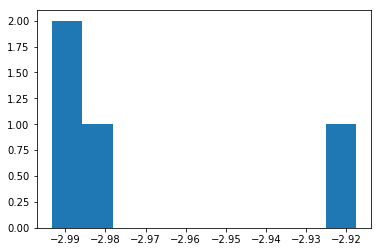

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.8008 -0.0807  1.1781]]
0.0230960845947
Training epoch 700
Iter: 700
D loss: -0.2199
G_loss: -0.1053
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7519  0.1035  1.2081]]
fake:
[[-0.6092 -0.547   0.5742]
 [ 0.1641 -0.7954 -0.5835]
 [ 0.7758 -0.2613  0.5743]]
-2.99844


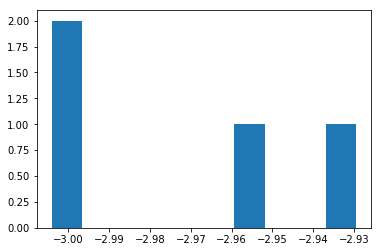

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7342  0.152   1.2139]]
0.0212209224701
Training epoch 800
Iter: 800
D loss: -0.2203
G_loss: -0.1098
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7498  0.1096  1.2089]]
fake:
[[-0.6211 -0.5186  0.5876]
 [ 0.133  -0.8086 -0.5731]
 [ 0.7724 -0.2778  0.5712]]
-2.97832


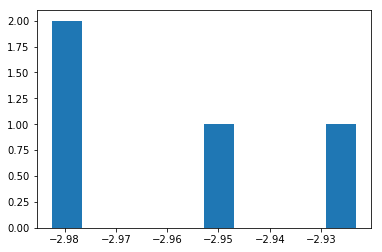

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7513  0.1054  1.2084]]
0.0211780071259
Training epoch 900
Iter: 900
D loss: -0.2204
G_loss: -0.1087
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.6041  0.4063  1.227 ]]
fake:
[[-0.6313 -0.4915  0.5999]
 [ 0.1034 -0.82   -0.563 ]
 [ 0.7686 -0.2934  0.5685]]
-2.95764


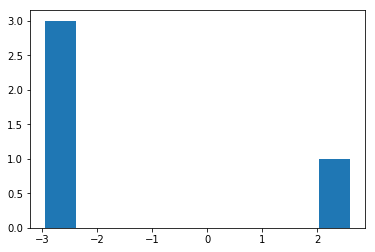

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7577  0.0864  1.2059]]
0.0213079452515
Training epoch 1000
Iter: 1000
D loss: -0.2202
G_loss: -0.11
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7454  0.122   1.2104]]
fake:
[[-0.61   -0.5453  0.575 ]
 [ 0.1622 -0.7962 -0.5829]
 [ 0.7756 -0.2623  0.5741]]
-2.99503


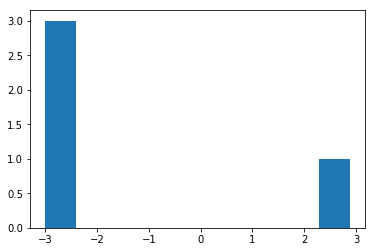

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.738   0.142   1.2128]]
0.0211658477783
Training epoch 1100
Iter: 1100
D loss: -0.2204
G_loss: -0.1099
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7374  0.1436  1.2129]]
fake:
[[-0.6116 -0.5416  0.5768]
 [ 0.1582 -0.798  -0.5816]
 [ 0.7752 -0.2644  0.5737]]
-2.99888


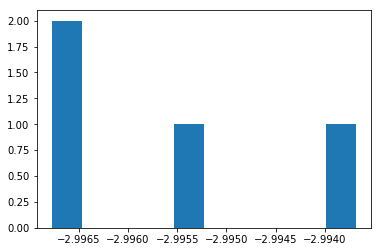

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7367  0.1456  1.2132]]
0.0203111171722
Training epoch 1200
Iter: 1200
D loss: -0.2204
G_loss: -0.1099
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7635  0.068   1.2033]]
fake:
[[-0.6199 -0.5216  0.5862]
 [ 0.1363 -0.8072 -0.5743]
 [ 0.7728 -0.2761  0.5715]]
-2.96796


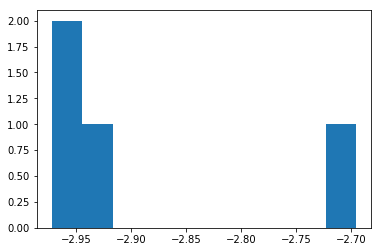

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7475  0.1163  1.2097]]
0.021301984787
Training epoch 1300
Iter: 1300
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7465  0.119   1.2101]]
fake:
[[-0.6186 -0.5248  0.5847]
 [ 0.1397 -0.8058 -0.5754]
 [ 0.7732 -0.2743  0.5718]]
-2.97795


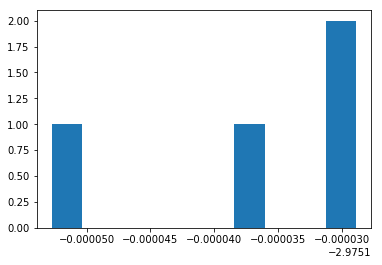

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7465  0.119   1.2101]]
0.021369934082
Training epoch 1400
Iter: 1400
D loss: -0.2204
G_loss: -0.1101
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7516  0.1045  1.2083]]
fake:
[[-0.6208 -0.5193  0.5873]
 [ 0.1337 -0.8083 -0.5734]
 [ 0.7725 -0.2774  0.5713]]
-2.96821


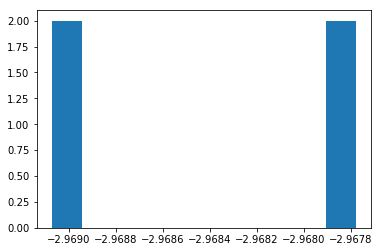

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.8201 -0.4079  1.094 ]]
0.0209648609161
Training epoch 1500
Iter: 1500
D loss: -0.2196
G_loss: -0.1101
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7512  0.1057  1.2084]]
fake:
[[-0.6222 -0.5157  0.5889]
 [ 0.1298 -0.8099 -0.5721]
 [ 0.772  -0.2795  0.5709]]
-2.96097


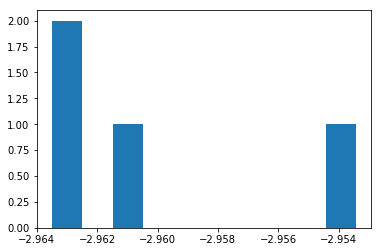

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7521  0.103   1.2081]]
0.0212111473083
Training epoch 1600
Iter: 1600
D loss: -0.2204
G_loss: -0.1101
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7223  0.1818  1.2169]]
fake:
[[-0.5998 -0.5675  0.5641]
 [ 0.1869 -0.7849 -0.5908]
 [ 0.778  -0.249   0.5768]]
-3.03073


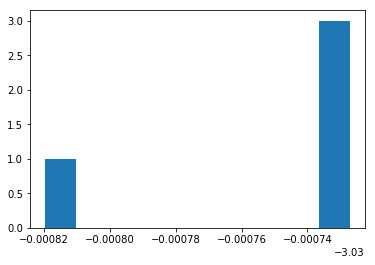

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7222  0.182   1.2169]]
0.0208189487457
Training epoch 1700
Iter: 1700
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7452  0.1225  1.2105]]
fake:
[[-0.6189 -0.5241  0.5851]
 [ 0.1389 -0.8062 -0.5751]
 [ 0.7731 -0.2747  0.5718]]
-2.97752


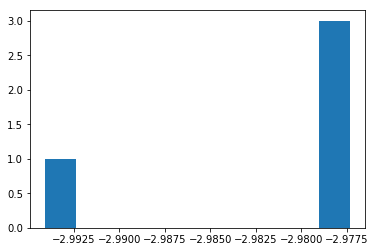

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7469  0.1179  1.2099]]
0.0212700366974
Training epoch 1800
Iter: 1800
D loss: -0.2197
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7401  0.1365  1.2121]]
fake:
[[-0.6193 -0.523   0.5855]
 [ 0.1378 -0.8066 -0.5748]
 [ 0.7729 -0.2753  0.5716]]
-2.97157


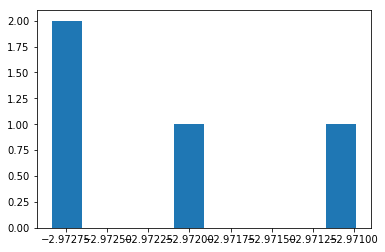

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7474  0.1164  1.2097]]
0.0209231376648
Training epoch 1900
Iter: 1900
D loss: -0.2204
G_loss: -0.1092
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7375  0.1433  1.2129]]
fake:
[[-0.6118 -0.5411  0.577 ]
 [ 0.1577 -0.7982 -0.5814]
 [ 0.7752 -0.2647  0.5736]]
-2.99774


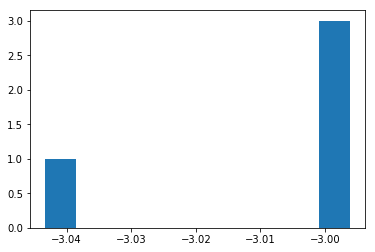

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7376  0.1431  1.2129]]
0.0206370353699
Training epoch 2000
Iter: 2000
D loss: -0.2203
G_loss: -0.1101
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7342  0.1521  1.2139]]
fake:
[[-0.6091 -0.5473  0.574 ]
 [ 0.1645 -0.7952 -0.5836]
 [ 0.7759 -0.2611  0.5744]]
-3.00362


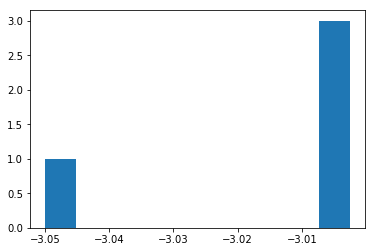

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.733   0.1551  1.2142]]
0.0215802192688
Training epoch 2100
Iter: 2100
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7392  0.1389  1.2124]]
fake:
[[-0.6181 -0.526   0.5841]
 [ 0.1411 -0.8053 -0.5759]
 [ 0.7733 -0.2735  0.572 ]]
-2.976


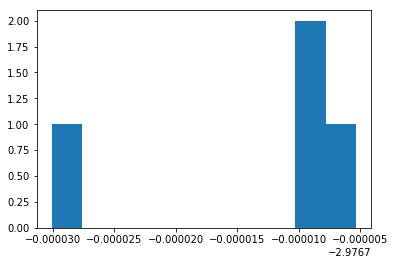

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7458  0.1208  1.2103]]
0.0208148956299
Training epoch 2200
Iter: 2200
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7445  0.1244  1.2107]]
fake:
[[-0.6185 -0.525   0.5846]
 [ 0.14   -0.8057 -0.5755]
 [ 0.7732 -0.2741  0.5719]]
-2.97992


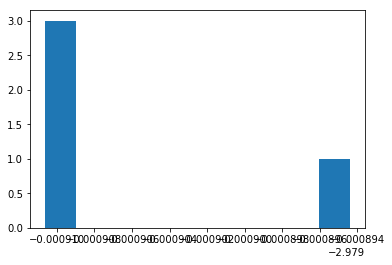

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7445  0.1245  1.2107]]
0.0213840007782
Training epoch 2300
Iter: 2300
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7457  0.1213  1.2103]]
fake:
[[-0.618  -0.5264  0.584 ]
 [ 0.1414 -0.8051 -0.576 ]
 [ 0.7734 -0.2734  0.572 ]]
-2.97705


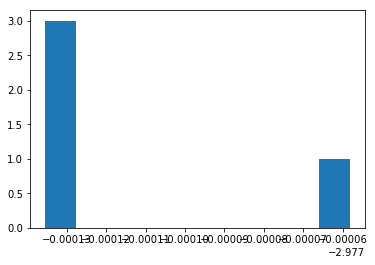

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7452  0.1225  1.2105]]
0.0212478637695
Training epoch 2400
Iter: 2400
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7451  0.123   1.2105]]
fake:
[[-0.6187 -0.5247  0.5848]
 [ 0.1396 -0.8059 -0.5754]
 [ 0.7732 -0.2743  0.5718]]
-2.97927


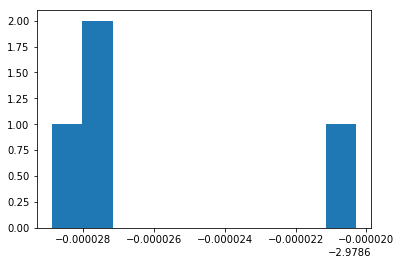

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7451  0.123   1.2105]]
0.0225629806519
Training epoch 2500
Iter: 2500
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7385  0.1409  1.2126]]
fake:
[[-0.6124 -0.5397  0.5777]
 [ 0.1561 -0.7989 -0.5809]
 [ 0.775  -0.2655  0.5735]]
-2.99434


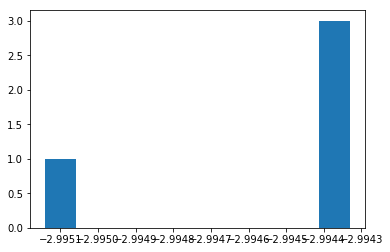

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7385  0.1409  1.2126]]
0.0215511322021
Training epoch 2600
Iter: 2600
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7416  0.1324  1.2117]]
fake:
[[-0.6143 -0.5352  0.5798]
 [ 0.1512 -0.801  -0.5793]
 [ 0.7745 -0.2682  0.573 ]]
-2.98878


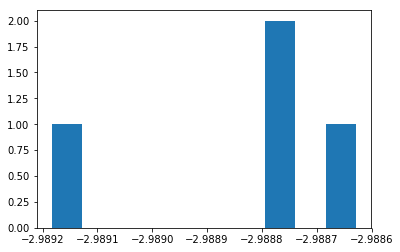

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7408  0.1345  1.2119]]
0.0205519199371
Training epoch 2700
Iter: 2700
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7439  0.1261  1.2109]]
fake:
[[-0.6166 -0.5297  0.5824]
 [ 0.1451 -0.8036 -0.5772]
 [ 0.7738 -0.2714  0.5724]]
-2.99018


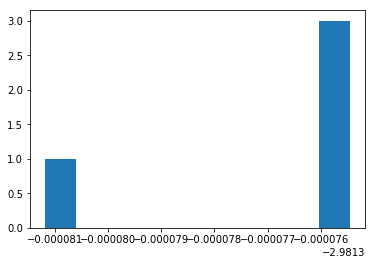

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7439  0.1261  1.2109]]
0.0211520195007
Training epoch 2800
Iter: 2800
D loss: -0.2194
G_loss: -0.11
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7496  0.1103  1.209 ]]
fake:
[[-0.621  -0.5189  0.5875]
 [ 0.1332 -0.8085 -0.5732]
 [ 0.7724 -0.2777  0.5712]]
-2.96751


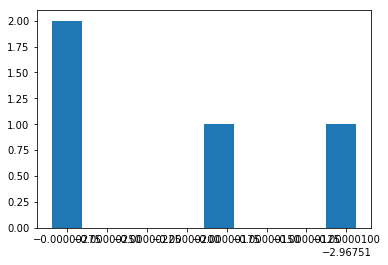

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7496  0.1103  1.209 ]]
0.021115064621
Training epoch 2900
Iter: 2900
D loss: -0.2202
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7338  0.1532  1.214 ]]
fake:
[[-0.6088 -0.548   0.5737]
 [ 0.1653 -0.7948 -0.5839]
 [ 0.7759 -0.2606  0.5744]]
-3.00519


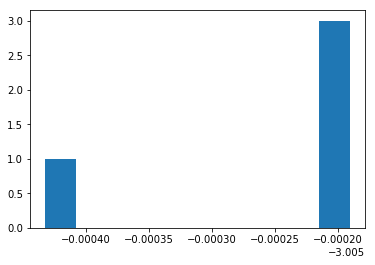

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7338  0.1532  1.214 ]]
0.0215358734131
Training epoch 3000
Iter: 3000
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7404  0.1358  1.2121]]
fake:
[[-0.6139 -0.5362  0.5793]
 [ 0.1523 -0.8005 -0.5796]
 [ 0.7746 -0.2676  0.5731]]
-2.98987


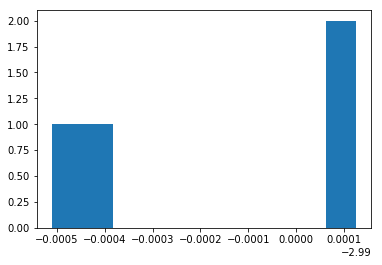

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7395  0.138   1.2123]]
0.0215489864349
Training epoch 3100
Iter: 3100
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7527  0.1011  1.2078]]
fake:
[[-0.6235 -0.5126  0.5904]
 [ 0.1264 -0.8112 -0.5709]
 [ 0.7716 -0.2813  0.5706]]
-2.95952


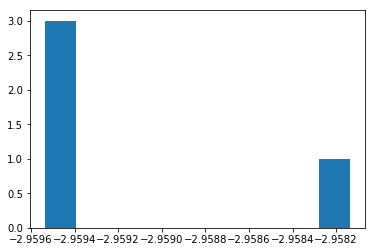

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7527  0.1011  1.2078]]
0.0213971138
Training epoch 3200
Iter: 3200
D loss: -0.2203
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7336  0.1536  1.214 ]]
fake:
[[-0.6086 -0.5483  0.5735]
 [ 0.1656 -0.7947 -0.584 ]
 [ 0.776  -0.2605  0.5745]]
-3.00555


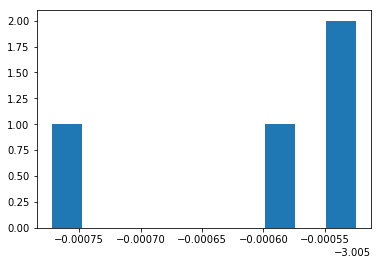

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7336  0.1536  1.214 ]]
0.0205540657043
Training epoch 3300
Iter: 3300
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.738   0.1421  1.2128]]
fake:
[[-0.612  -0.5405  0.5773]
 [ 0.157  -0.7985 -0.5812]
 [ 0.7751 -0.265   0.5736]]
-2.99428


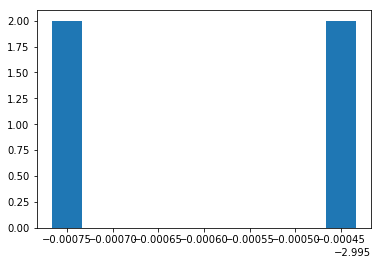

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7379  0.1423  1.2128]]
0.0212152004242
Training epoch 3400
Iter: 3400
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7404  0.1357  1.212 ]]
fake:
[[-0.6124 -0.5397  0.5777]
 [ 0.1561 -0.7989 -0.5809]
 [ 0.775  -0.2656  0.5735]]
-2.99273


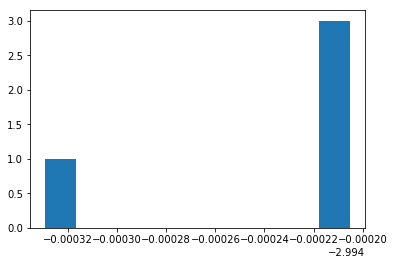

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7404  0.1358  1.2121]]
0.0213899612427
Training epoch 3500
Iter: 3500
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.739   0.1395  1.2125]]
fake:
[[-0.6128 -0.5388  0.5781]
 [ 0.1551 -0.7993 -0.5805]
 [ 0.7749 -0.2661  0.5734]]
-2.99283


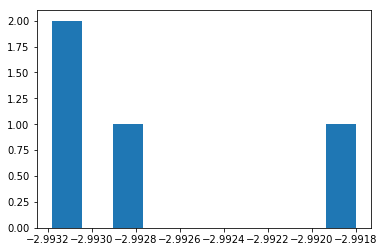

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.74    0.1367  1.2122]]
0.0221390724182
Training epoch 3600
Iter: 3600
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7535  0.0988  1.2075]]
fake:
[[-0.6242 -0.5106  0.5913]
 [ 0.1242 -0.8121 -0.5702]
 [ 0.7713 -0.2825  0.5704]]
-2.95703


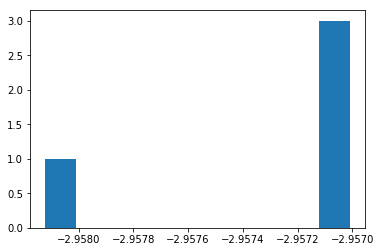

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7537  0.0983  1.2075]]
0.0207059383392
Training epoch 3700
Iter: 3700
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7542  0.0968  1.2073]]
fake:
[[-0.6246 -0.5096  0.5918]
 [ 0.1231 -0.8125 -0.5698]
 [ 0.7712 -0.2831  0.5702]]
-2.95575


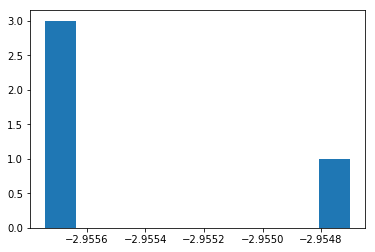

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7539  0.0977  1.2074]]
0.0259230136871
Training epoch 3800
Iter: 3800
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7518  0.1038  1.2082]]
fake:
[[-0.6227 -0.5145  0.5895]
 [ 0.1284 -0.8104 -0.5716]
 [ 0.7718 -0.2803  0.5707]]
-2.96193


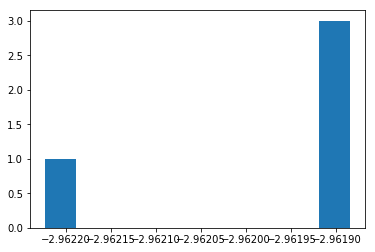

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7518  0.1038  1.2082]]
0.0243101119995
Training epoch 3900
Iter: 3900
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7455  0.1216  1.2104]]
fake:
[[-0.6179 -0.5266  0.5839]
 [ 0.1417 -0.805  -0.5761]
 [ 0.7734 -0.2732  0.572 ]]
-2.97744


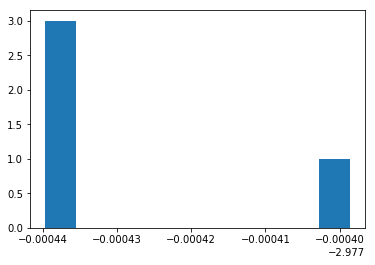

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7456  0.1216  1.2104]]
0.023472070694
Training epoch 4000
Iter: 4000
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7406  0.1353  1.212 ]]
fake:
[[-0.614  -0.5359  0.5795]
 [ 0.1519 -0.8007 -0.5795]
 [ 0.7745 -0.2678  0.5731]]
-2.98972


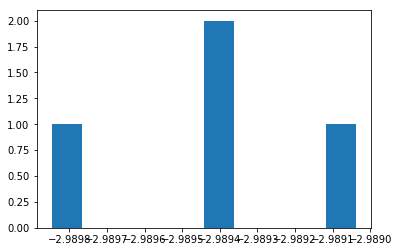

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7402  0.1364  1.2121]]
0.0217368602753
Training epoch 4100
Iter: 4100
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7395  0.1381  1.2123]]
fake:
[[-0.6132 -0.5378  0.5786]
 [ 0.154  -0.7998 -0.5802]
 [ 0.7748 -0.2667  0.5733]]
-2.99187


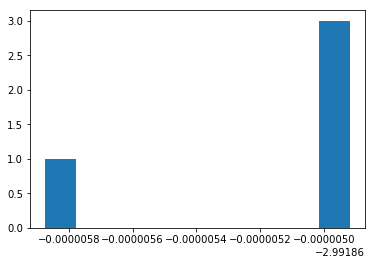

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7395  0.1381  1.2123]]
0.023973941803
Training epoch 4200
Iter: 4200
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7476  0.1158  1.2097]]
fake:
[[-0.6192 -0.5235  0.5853]
 [ 0.1383 -0.8064 -0.5749]
 [ 0.773  -0.275   0.5717]]
-2.97242


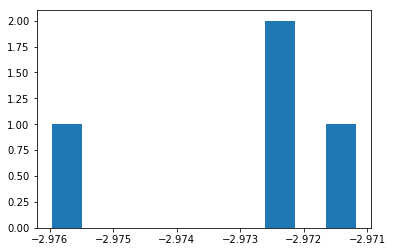

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7476  0.1159  1.2097]]
0.0465779304504
Training epoch 4300
Iter: 4300
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7532  0.0997  1.2076]]
fake:
[[-0.6239 -0.5116  0.5908]
 [ 0.1253 -0.8117 -0.5705]
 [ 0.7714 -0.2819  0.5704]]
-2.95824


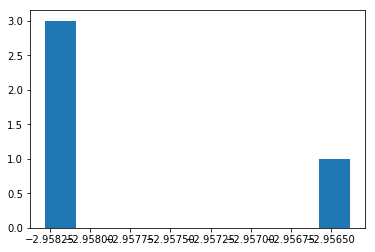

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7532  0.0997  1.2076]]
0.0211429595947
Training epoch 4400
Iter: 4400
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7375  0.1435  1.2129]]
fake:
[[-0.6116 -0.5415  0.5768]
 [ 0.1581 -0.798  -0.5815]
 [ 0.7752 -0.2645  0.5737]]
-2.99667


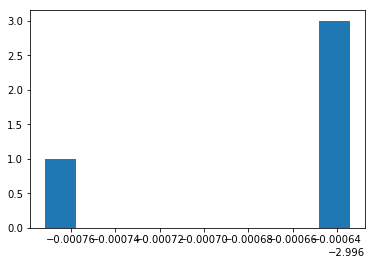

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7375  0.1435  1.2129]]
0.0215091705322
Training epoch 4500
Iter: 4500
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7486  0.1131  1.2093]]
fake:
[[-0.6203 -0.5208  0.5866]
 [ 0.1353 -0.8077 -0.5739]
 [ 0.7726 -0.2766  0.5714]]
-2.96989


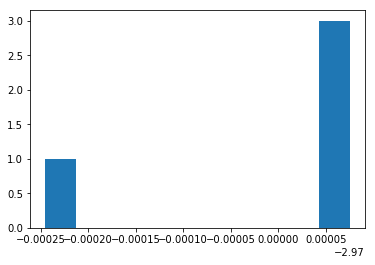

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7486  0.1131  1.2093]]
0.0231409072876
Training epoch 4600
Iter: 4600
D loss: -0.2204
G_loss: -0.1102
real:
[[-0.0725 -0.0715 -1.7212]
 [-0.8925  0.3145 -0.4713]
 [-0.2245 -0.1035  1.0027]
 [ 1.1895 -0.1395  1.1898]]
fake:
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7542  0.0968  1.2073]]
fake:
[[-0.6245 -0.5099  0.5916]
 [ 0.1234 -0.8124 -0.5699]
 [ 0.7712 -0.2829  0.5703]]
-2.9594


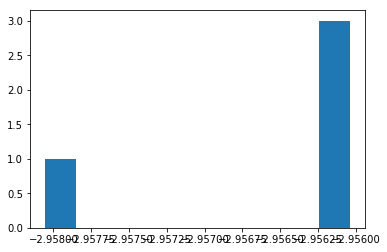

/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2
[[ 0.152   0.032  -2.724 ]
 [-0.668   0.418  -1.474 ]
 [ 0.      0.      0.    ]
 [-0.7541  0.0972  1.2073]]


KeyboardInterrupt: 

In [37]:
every = 100
#train_dataset = features[:S]
train_dataset = features[:1]*S
n_train = len(train_dataset)

for it in range(1000000):
    a = time.time()
    random.shuffle(train_dataset)
    
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        
        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    
    if it % every == 0:
        
        print(time.time()-a)
        print("Training epoch %d" %it)
                
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        feed_dict = construct_feed_dict(features[:1]*S, 0, S, shuffle_inds=False, keep_prob_val=1.)

        print("real:")
        print(feed_dict[mol_xyz][0][:4])
        print("fake:")
        print(sess.run(G_sample, feed_dict=feed_dict)[0][:4])
        print("fake:")
        print(sess.run(rot_mat_i, feed_dict=feed_dict))

        print(np.mean(sess.run(dihed, feed_dict=feed_dict)[:, 0]))
        plt.hist(sess.run(dihed, feed_dict=feed_dict)[:, 0])
        plt.show()
        
        
        generate_molecule(features[0][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[0][0].split(".")[0].split("/")[-1], it))
        #generate_molecule(features[1][0], sess.run(G_sample, feed_dict=feed_dict)[1], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[1][0].split(".")[0].split("/")[-1], it))

        #feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False, keep_prob_val=1.)
        #generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))

        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))

    #random.shuffle(train_dataset)



In [ ]:
feed_dict = construct_feed_dict(features, 0, S, shuffle_inds=False)

sess.run(G_sample, feed_dict=feed_dict)[0]

In [ ]:
features[0]

In [ ]:
feed_dict = construct_feed_dict(features, len(features)-S, len(features), shuffle_inds=False)
generate_molecule(features[-1][0], sess.run(G_sample, feed_dict=feed_dict)[0], "/home/evan/Documents/deep_docking/dcgan_pg/DCGAN-tensorflow/generated_mols/%s_test%d.mol" %(features[-1][0].split(".")[0].split("/")[-1], it))


In [ ]:
np.min(results[0])



In [ ]:
np.where(features[0][1][:,:,:,:-1] == 1)

In [ ]:
"""
def discriminator(W_list, b_list, h_list, L_list, n_layers, mols):
    mols = tf.add(mols, mol_noise)
    with tf.device('/gpu:0'):
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        h_final = h_list[-1]
        dist_matrix = tf.concat([tf.reshape(compute_distance_matrix(tf.reshape(mol, [B, 3])), (1, B, B)) for mol in tf.split(mols, S, axis=0)], axis=0)
        print("dist_matrix")
        print(dist_matrix)
        #dist_matrix = compute_distance_matrix(mol)
        bond_dist_gen = tf.multiply(dist_matrix, adj_matrix)
        wrong_bond_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(bond_dist_mat, bond_dist_gen)), axis=[1,2]), lam1), (S,1)), n_bonds)
        print("wrong_bond_loss")
        print(wrong_bond_loss)

        angles = []
        for i in range(0, B):
            for j in range(0, B):
                ij = mols[:, i,:] - mols[:,j,:]
                ij = ij / tf.sqrt(tf.reduce_sum(tf.square(ij), 1, keep_dims=True))
                #ij shape should be (S, 3)
               # print("ij")
                #print(ij)
                for k in range(0,B):
                    ik = mols[:,i,:] - mols[:,k,:]
                    ik = ik / tf.sqrt(tf.reduce_sum(tf.square(ik), 1, keep_dims=True))

                    #ik shape should be (S, 3)
                    #if i == 0 and j == 0 and k == 0: 
                    #   print("ik")
                     #   print(ik)
                        
                    dp = tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True)
                    #dp shape should be (S,1)
                    #if i ==0 and j ==0 and k==0:
                    #    print("dp")
                    #    print(dp)
                    if i == j or i == k or j == k:
                        angle = tf.Variable(tf.constant(np.zeros([4,1]).astype(np.float32)))
                    else:
                        angle = tf.acos(tf.clip_by_value(tf.reduce_sum(tf.multiply(ij, ik), axis=1, keep_dims=True), -1.0, 1.0))
                    #if i ==0 and j==0 and k==0:
                        #print("angle")
                        #print(angle)
                    angles.append(angle)
        angles_gen = tf.reshape(tf.concat(angles, axis=1), [S, B, B, B])
        angles_gen = tf.multiply(angles_gen, angle_tuples)
        wrong_angles_loss = tf.divide(tf.reshape(tf.multiply(tf.reduce_sum(tf.square(tf.subtract(angle_tensor, angles_gen)), axis=[1,2,3]), lam2), (S,1)), n_angles)
                
        feat_i = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_i = tf.tile(feat_i, [1, 1, B, 1])
        
        feat_j = tf.reshape(h_final, (S, B, 1, L_list[n_layers]))
        feat_j = tf.transpose(feat_j, perm=[0, 2, 1, 3])
        feat_j = tf.tile(feat_j, [1, B, 1, 1])
        
        d_h1 = tf.concat([tf.reshape(dist_matrix, [S, B, B, 1]), feat_i, feat_j], axis=3)
        d_h1 = tf.reshape(d_h1, [S, B, B*(L_list[n_layers]*2+1)])
        d_h2 = leaky_relu(tf.matmul(d_h1, d_w1) + d_b1)
        d_h2 = tf.divide(tf.reduce_sum(tf.matmul(d_h2, d_w2) + d_b2, axis=1), n_bonds)#, axis=1
        print("d_h2")
        print(d_h2)
        
    
    return(wrong_bond_loss + wrong_angles_loss + d_h2, bond_dist_gen, angles_gen, wrong_bond_loss, wrong_angles_loss)
"""

In [ ]:
mol = Chem.MolFromMol2File(ligand_files[0])
c = mol.GetConformer(0)

In [ ]:
c.SetAtomPosition(0, [0., 0., 0.])

In [ ]:
np.where(features[2][1][:,:,:,:-1] == 1)

In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [ ]:
features[1][0]

In [ ]:
mol = Chem.MolFromMol2File(features[1][0])
mol.GetNumAtoms()

In [ ]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

In [ ]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)